In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import random
import os
from sklearn.model_selection import train_test_split

In [44]:
print(os.getcwd())
os.chdir('c:\\Users\\Gyanprakash\\Desktop\\Data-Science\\NLP')

c:\Users\Gyanprakash\Desktop\Data-Science\NLP


In [45]:
df = pd.read_csv(r'LSTM/fake_news_classifier/train.csv')

In [46]:
def random_values(feature_name:str,end=6):
    for i in range(0,end):
        # print(df[feature_name].sample(end))
        indx = np.random.randint(df.shape[0])
        print(f'{indx}: {df[feature_name].iloc[indx]}')

In [47]:
# df

In [48]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [49]:
df = df.dropna()
df.reset_index(inplace=True)

In [50]:
df.isnull().sum()

index     0
id        0
title     0
author    0
text      0
label     0
dtype: int64

In [51]:
df.shape

(18285, 6)

In [52]:
print(df.shape)
df = df.iloc[:5000]
print(df.shape)

(18285, 6)
(5000, 6)


In [ ]:
X = df['title']
df = df.drop('index',axis=1)
y = df['label']
X

In [54]:
## tensorflow
from keras.layers import (Embedding,
                          LSTM,
                          Dense,
                          Bidirectional)

from keras.utils import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer

## NLTK
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tqdm import tqdm

In [55]:
ps = PorterStemmer()

In [56]:
## Preprocessing
corpus = []
for i in tqdm(range(0,len(X))):
    txt = re.sub('[^a-zA-Z]',' ',X[i])
    txt = txt.lower()
    txt = txt.split()

    txt = [ps.stem(word) for word in txt if not word in stopwords.words('english')]
    txt = ' '.join(txt)
    corpus.append(txt)

  1%|          | 54/5000 [00:00<00:18, 273.70it/s]

100%|██████████| 5000/5000 [00:22<00:00, 223.05it/s]


In [57]:
len(corpus)

5000

In [58]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts=corpus)

In [59]:
corpus_docs = tokenizer.texts_to_sequences(texts=corpus) # I am assigning number to text. Transforming each text in texts to a sequence of integers.

In [60]:
print(f' my vocab has {len(tokenizer.word_index)} unique words')

 my vocab has 7553 unique words


In [61]:
# Checking the max lenght of sentence present in the corpus
max_len = 0
for i in range(0, len(corpus_docs)):
    try:
        if len(corpus_docs[i]) > max_len:
            max_len = len(corpus_docs[i])
    except:
        pass

print(f'words max len in corpus is: {max_len}')


words max len in corpus is: 47


7

In [70]:
len(corpus_docs[4999])
padded_docs = pad_sequences(sequences=corpus_docs,maxlen=47,padding='post')
len(padded_docs[4999])

47

## Model

In [65]:
X.shape[0] , len(tokenizer.word_index)+1

(5000, 7554)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
     np.array(padded_docs), np.array(y), test_size=0.23, random_state=42)

In [67]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3850, 47)
X_test shape: (1150, 47)
y_train shape: (3850,)
y_test shape: (1150,)


In [73]:
from keras.layers import BatchNormalization, Dropout, Bidirectional, LSTM, Embedding, Dense
from keras.losses import binary_crossentropy
from tensorflow import keras
from keras.callbacks import LearningRateScheduler , EarlyStopping

initializer = keras.initializers.HeNormal() # Initializing the weights so that the should have right weight from start of the training.
regularizer = keras.regularizers.l2(l2=0.4) # penalty term.
activation_lstm = keras.activations.elu # this is optimized version of relu

model_features = 100 # this is for embedding layer because the embedding layer creat features like word2Vec internally.
model = keras.Sequential(name='LSTM_model')

model.add(Embedding(
    input_dim=len(tokenizer.word_index)+1,  # The "+1" accounts for the reserved index 0 in the word index (since word indices start from 1 and not 0)
    output_dim=model_features, input_length=47
))
model.add(Bidirectional(LSTM(units=16, activation=activation_lstm, kernel_regularizer=regularizer, kernel_initializer=initializer,return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.9))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=16, activation='relu',kernel_regularizer=regularizer,return_sequences=False))) 
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))


print(model.summary())


def lr_schedule(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * np.exp(-0.1)

# learning rate scheduler callback to descrese the learning rate gradually as the epochs increases So that my alogrithm could not jump out of Global minima.
lr_scheduler = LearningRateScheduler(lr_schedule)

# Early stopping to stop the Neural Network when we get same Validation accuracy
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)


# Reduce the learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, # Used Adam because this has not any major disadvantages with custom learning rate because the convergence was very unstable.
               loss=binary_crossentropy, # because solving the classification problem
                 metrics=['accuracy'])  # I don't need to write about this you know.

# Training the model with callbacks
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20,
                    batch_size=32, # I had tried different batch sizes but this has given my best results
                      callbacks=[lr_scheduler, early_stopping]) # these to prevent the NN from overfitting and scheduling learning rate to get optimum solution.

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 47, 100)           755400    
                                                                 
 bidirectional_19 (Bidirecti  (None, 47, 32)           14976     
 onal)                                                           
                                                                 
 batch_normalization_20 (Bat  (None, 47, 32)           128       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 47, 32)            0         
                                                                 
 batch_normalization_21 (Bat  (None, 47, 32)           128       
 chNormalization)                                                
                                                        

Text(0.5, 1.0, 'val_loss- 14.277 and loss- 12.443')

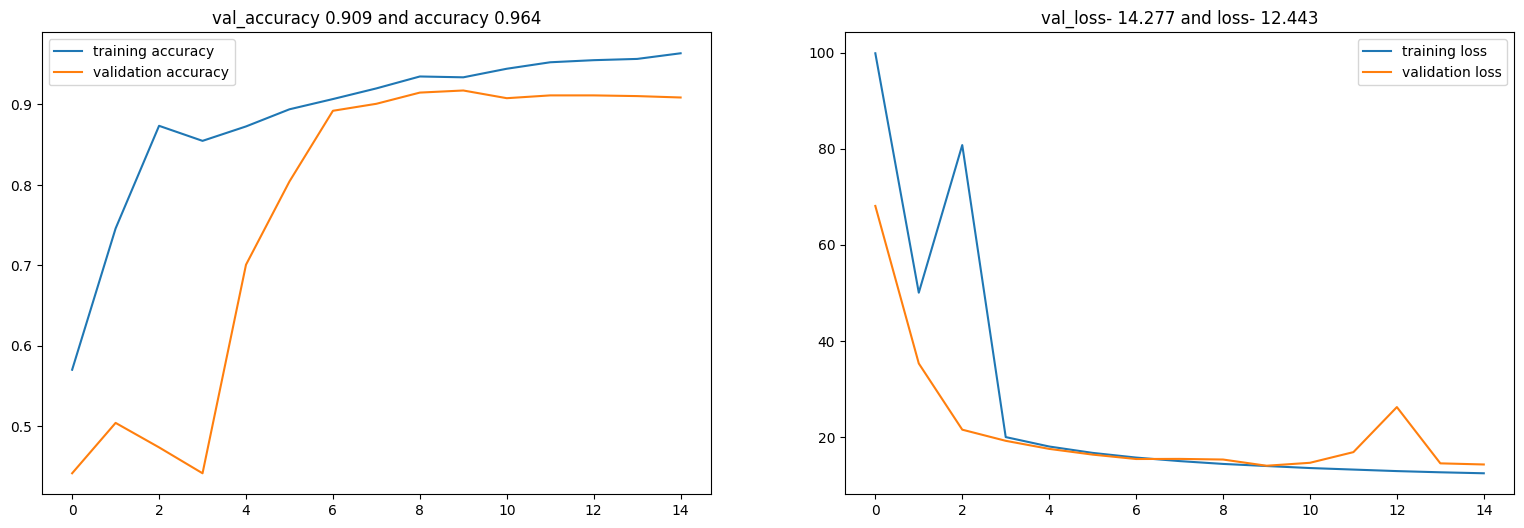

In [75]:
plt.subplots(nrows=1,ncols=2,figsize = (19,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])   
plt.legend(['training accuracy','validation accuracy'])
plt.title(f'val_accuracy {round(history.history["val_accuracy"][14],ndigits=3)} and accuracy {round(history.history["accuracy"][14],ndigits=3)}')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss','validation loss'])
plt.title(f'val_loss- {round(history.history["val_loss"][14],ndigits=3)} and loss- {round(history.history["loss"][14],ndigits=3)}')